In [271]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')

import numpy as np
import scipy.stats as stats
import pandas as pd

from scipy.spatial import distance
from sklearn.cluster import SpectralBiclustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from collections import Counter
import json
import re
import ast

import importlib

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import pickle
import nltk

import drawing_utils as drawing

import block_construction_helpers as bc

In [272]:
experiment_name = 'perceptual_chunks'

## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

# paths to silhouette data
silhouette_results_dir = os.path.join(results_dir, 'silhouette')
silhouette_csv_dir = os.path.join(silhouette_results_dir,'csv')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [273]:
# latest iteration name to include
iteration_name = 'pilot_0c'
iteration_names = ['pilot_0','pilot_0b','pilot_0c']

# variables to check integrity of data
numTrials = 8

In [274]:
# open pickled dataframes

trial_path_p = os.path.join(csv_dir,'perceptual_chunks_trial_{}.p'.format(iteration_name))
df_perc_trial = pickle.load( open(trial_path_p, "rb" ))

# not used in this analysis
# color_path_p = os.path.join(csv_dir,'perceptual_chunks_color_{}.p'.format(iteration_name))
# df_color = pickle.load( open(color_path_p, "rb" ))

In [276]:
# filter participant that didn't follow instructions
df_perc_trial = df_perc_trial[df_perc_trial.flag=='none']
# df_color = df_color[df_perc_trial.flag=='none']

In [277]:
# useful vars
ppts = np.sort(df_perc_trial.gameID.unique())
targets = np.sort(df_perc_trial.targetName.unique())
n_ppt = len(ppts)
print(str(n_ppt) + ' ppts loaded')

49 ppts loaded


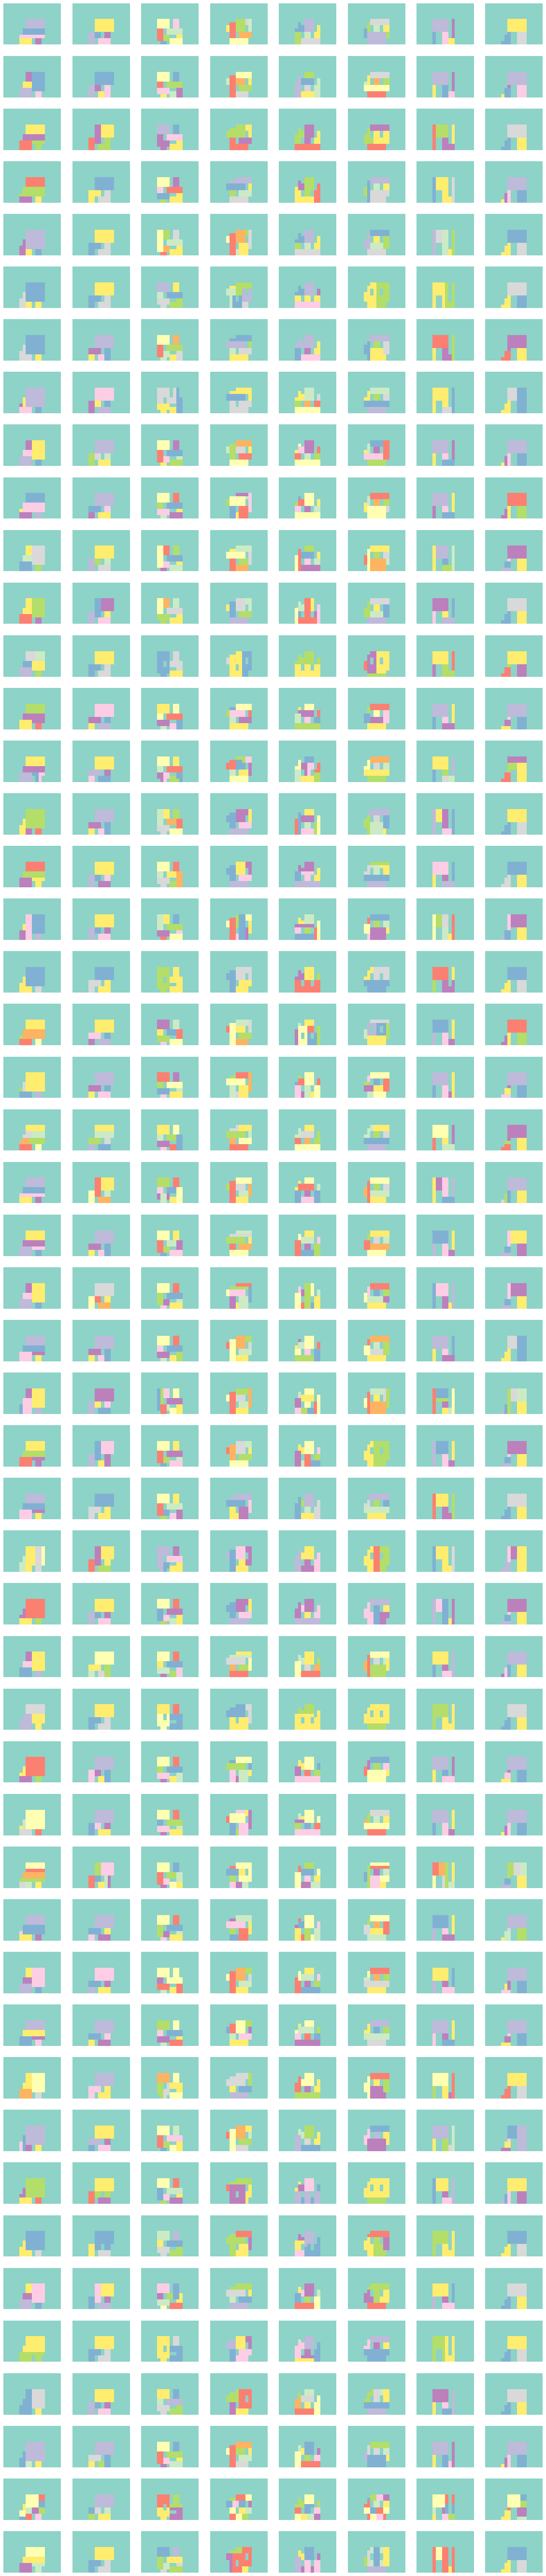

In [202]:
# visualize all participant's chunks

visualize = True

if visualize:

    fig, axs = plt.subplots(n_ppt, numTrials, figsize=(20,2*n_ppt))

    for i, ppt in enumerate(ppts):

        for j, target in enumerate(targets):

            chunks = df_perc_trial[(df_perc_trial.gameID==ppt) & (df_perc_trial.targetName==target)]['gameGrid'].iloc[0]
            chunks = np.rot90(chunks)
            axs[i,j].axis('off')
            axs[i,j].imshow(chunks, cmap='Set3')
            
            

### Define useful functions

In [278]:
def find_world_diffs(df_proc_world_states, window_sizes = range(2,10)):
    '''
    Find all chunks for all structures (so we can search for the structures that involve this chunk)

    a 'window-size' is the amount of states between first and final one considered INCLUSIVE. i.e. n is n-1 actions.
    i.e. window size 3 means 2 consecutive actions
    '''

    df_target_grouped = df_proc_world_states.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

    df_world_deltas = df_proc_trial.copy()

    for chunk_size in window_sizes:

        # for each reconstruction, get a list of ngrams of that length
        df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

        # find the chunks (world deltas) from those ngrams   
        df_ngrams['world_diff'] = df_ngrams['flatDiscreteWorldStr'].apply(lambda ngrams:
                                         ["".join([str(int(a)) for a in 
                                          list(
                                              np.logical_xor(np.array(list(ngram[-1])).astype(np.bool), 
                                              np.array(list(ngram[0])).astype(np.bool))
                                              )])
                                         for ngram in ngrams])

        df_ngrams = df_ngrams.rename(columns={"flatDiscreteWorldStr": str(chunk_size)+'_grams',
                                              "world_diff": str(chunk_size)+'_chunks'})

        df_world_deltas = df_world_deltas.merge(df_ngrams, how='left', on=['gameID','targetName','phase_extended'])
        
    # combine chunks from all window sized into list, so we can search for chunks in the entire reconstruction
    df_world_deltas['all_chunks'] = df_world_deltas[[(str(chunk_window)+'_chunks') \
                        for chunk_window in window_sizes if (str(chunk_window)+'_chunks') in df_world_deltas.columns]]\
    .apply(lambda row: [chunk for chunks in list(row) for chunk in chunks], axis=1)


    return df_world_deltas

In [279]:
# def find_perc_chunks_in_procedures(df_cluster_rows, 
#                                    df_proc_chunks,
#                                    min_cluster_members = 0):
#     '''
#     construct a new dataframe, searching for chunks 
#     '''

#     cluster_counts = pd.DataFrame()

#     for target in targets:

#     #     row = df_cluster_rows[(df_cluster_rows.targetName == target) & 
#     #                             (df_cluster_rows.cluster_method=='affinity_propagation') & 
#     #                             (df_cluster_rows.damping==0.74)].reset_index()

#         row = df_cluster_rows[(df_cluster_rows.targetName == target)].reset_index()


#         labels = row.cluster_object[0].labels_

#         for cluster_number, exemplar in enumerate(row.chunks[0]):

#             chunk_array = exemplar.reshape((8,8))

#             chunk_str = bc.cropped_chunk_to_string(chunk_array)

#             n_cluster_members = sum(labels == cluster_number)

#             if n_cluster_members >= min_cluster_members:

#                 props = {}

#                 for phase in ['pre','post']:

#                     subset_for_target = df_proc_chunks[#(df_proc_chunks.blockFell == False) &
#                                                        (df_proc_chunks.targetName == target) &
#                                                        (df_proc_chunks.phase == phase)]

#                     subset_with_chunk = subset_for_target[(subset_for_target['all_chunks']\
#                                                            .apply(lambda chunks: chunk_str in chunks))]

#                     row = {
#                         'targetName': target,
#                         'phase': phase,
#                         'chunk_str': chunk_str,
#                         'chunk_array': chunk_array,
#                         'n_cluster_members': n_cluster_members,
#         #                 'reconstructions_with_chunk': list(subset_with_chunk['discreteWorld']),
#                         'total_phase_reconstructions': subset_for_target.shape[0],
#                         'n_with_chunk': subset_with_chunk.shape[0],
#                         'chunk_id': cluster_number,
#                         'chunk_height': np.sum(np.dot(np.sum(chunk_array, axis=0),np.arange(8)))/np.sum(chunk_array) + 0.5,
#                         'proportion_with_chunk': subset_with_chunk.shape[0] / subset_for_target.shape[0]

#                     }

#                     props[phase] = subset_with_chunk.shape[0] /subset_for_target.shape[0]

#                     cluster_counts = cluster_counts.append(row,ignore_index=True)

#                 cluster_counts.loc[(cluster_counts.targetName == target) & (cluster_counts.chunk_str == chunk_str), 'difference'] = props['post'] - props['pre']

#                 cluster_counts.loc[(cluster_counts.targetName == target) & (cluster_counts.chunk_str == chunk_str), 'both_zero'] = \
#                     (props['pre'] == 0) & (props['post'] == 0)
                
#     return cluster_counts


In [280]:
def find_perc_chunks_in_procedures(perceptual_chunk_counters, 
                                   df_proc_chunks,
                                   min_count = 0):
    '''
    construct a new dataframe, searching for chunks 
    '''

    occurrences_in_procedures = pd.DataFrame()

    for target in targets:
        
        for i, (chunk_str, count) in enumerate(perceptual_chunk_counters[target].items()):

            if count >= min_count:

                props = {}

                for phase in ['pre','post']:
                    
                    subset_for_target = df_proc_chunks[(df_proc_chunks.blockFell == False) &
                                                       (df_proc_chunks.targetName == target) &
                                                       (df_proc_chunks.phase == phase)]

                    # check all precomputed chunks (of window sizes selected above) for presence of chunk
                    subset_with_chunk = subset_for_target[(subset_for_target['all_chunks']\
                                                           .apply(lambda chunks: chunk_str in chunks))]
                    
                    chunk_array = bc.chunk_str_to_cropped_array(chunk_str)
                    
                    
                    
                    if subset_with_chunk.shape[0]:
                        n_with_chunk = subset_with_chunk.shape[0]
                        props[phase] = subset_with_chunk.shape[0] / subset_for_target.shape[0]
                    else:
                        n_with_chunk = 0
                        props[phase] = 0

                    row = {
                        'targetName': target,
                        'phase': phase,
                        'chunk_str': chunk_str,
        #                 'reconstructions_with_chunk': list(subset_with_chunk['discreteWorld']),
                        'total_phase_reconstructions': subset_for_target.shape[0],
                        'n_with_chunk': n_with_chunk,
                        'chunk_height': np.sum(np.dot(np.sum(chunk_array, axis=0),np.arange(8)))/np.sum(chunk_array) + 0.5,
                        'proportion_with_chunk': props[phase],
                        'perceptual_count': count,
                        'perceptual_rank': i

                    }

                    occurrences_in_procedures = occurrences_in_procedures.append(row, ignore_index=True)

                occurrences_in_procedures.loc[(occurrences_in_procedures.targetName == target) & (occurrences_in_procedures.chunk_str == chunk_str), 'difference'] = props['post'] - props['pre']

                occurrences_in_procedures.loc[(occurrences_in_procedures.targetName == target) & (occurrences_in_procedures.chunk_str == chunk_str), 'both_zero'] = \
                    (props['pre'] == 0) & (props['post'] == 0)
                
    return occurrences_in_procedures


### Find most popular perceptual chunks for each structure

In [281]:
# for each structure, throw all chunks from all decompositions into a giant list

def addPerceptualChunks(chunk_list, decomposition, group_number):
    '''
    Checks whether a chunk with that group number exists in the decomposition and adds it to chunk_list 
    '''
    chunk = (decomposition==group_number)*1
    if chunk.any():
        chunk_list.append(bc.cropped_chunk_to_string(chunk))
        
        
# create dict of target to chunk list
perceptual_chunks = {}

for target in targets:
    
    perceptual_chunks[target] = []
    
    for group in range(1,9):
        df_perc_trial[df_perc_trial.targetName==target].structureGrid.apply(\
            lambda decomposition: addPerceptualChunks(perceptual_chunks[target],
                                                                        decomposition,
                                                                        group))

# count and sort chunks
perceptual_chunk_counters = {target: dict(Counter(perceptual_chunks[target]).most_common()) for target in targets}

In [368]:
# pickle.dump(perceptual_chunk_counters, open("perceptual_chunk_counters.p", "wb" ))

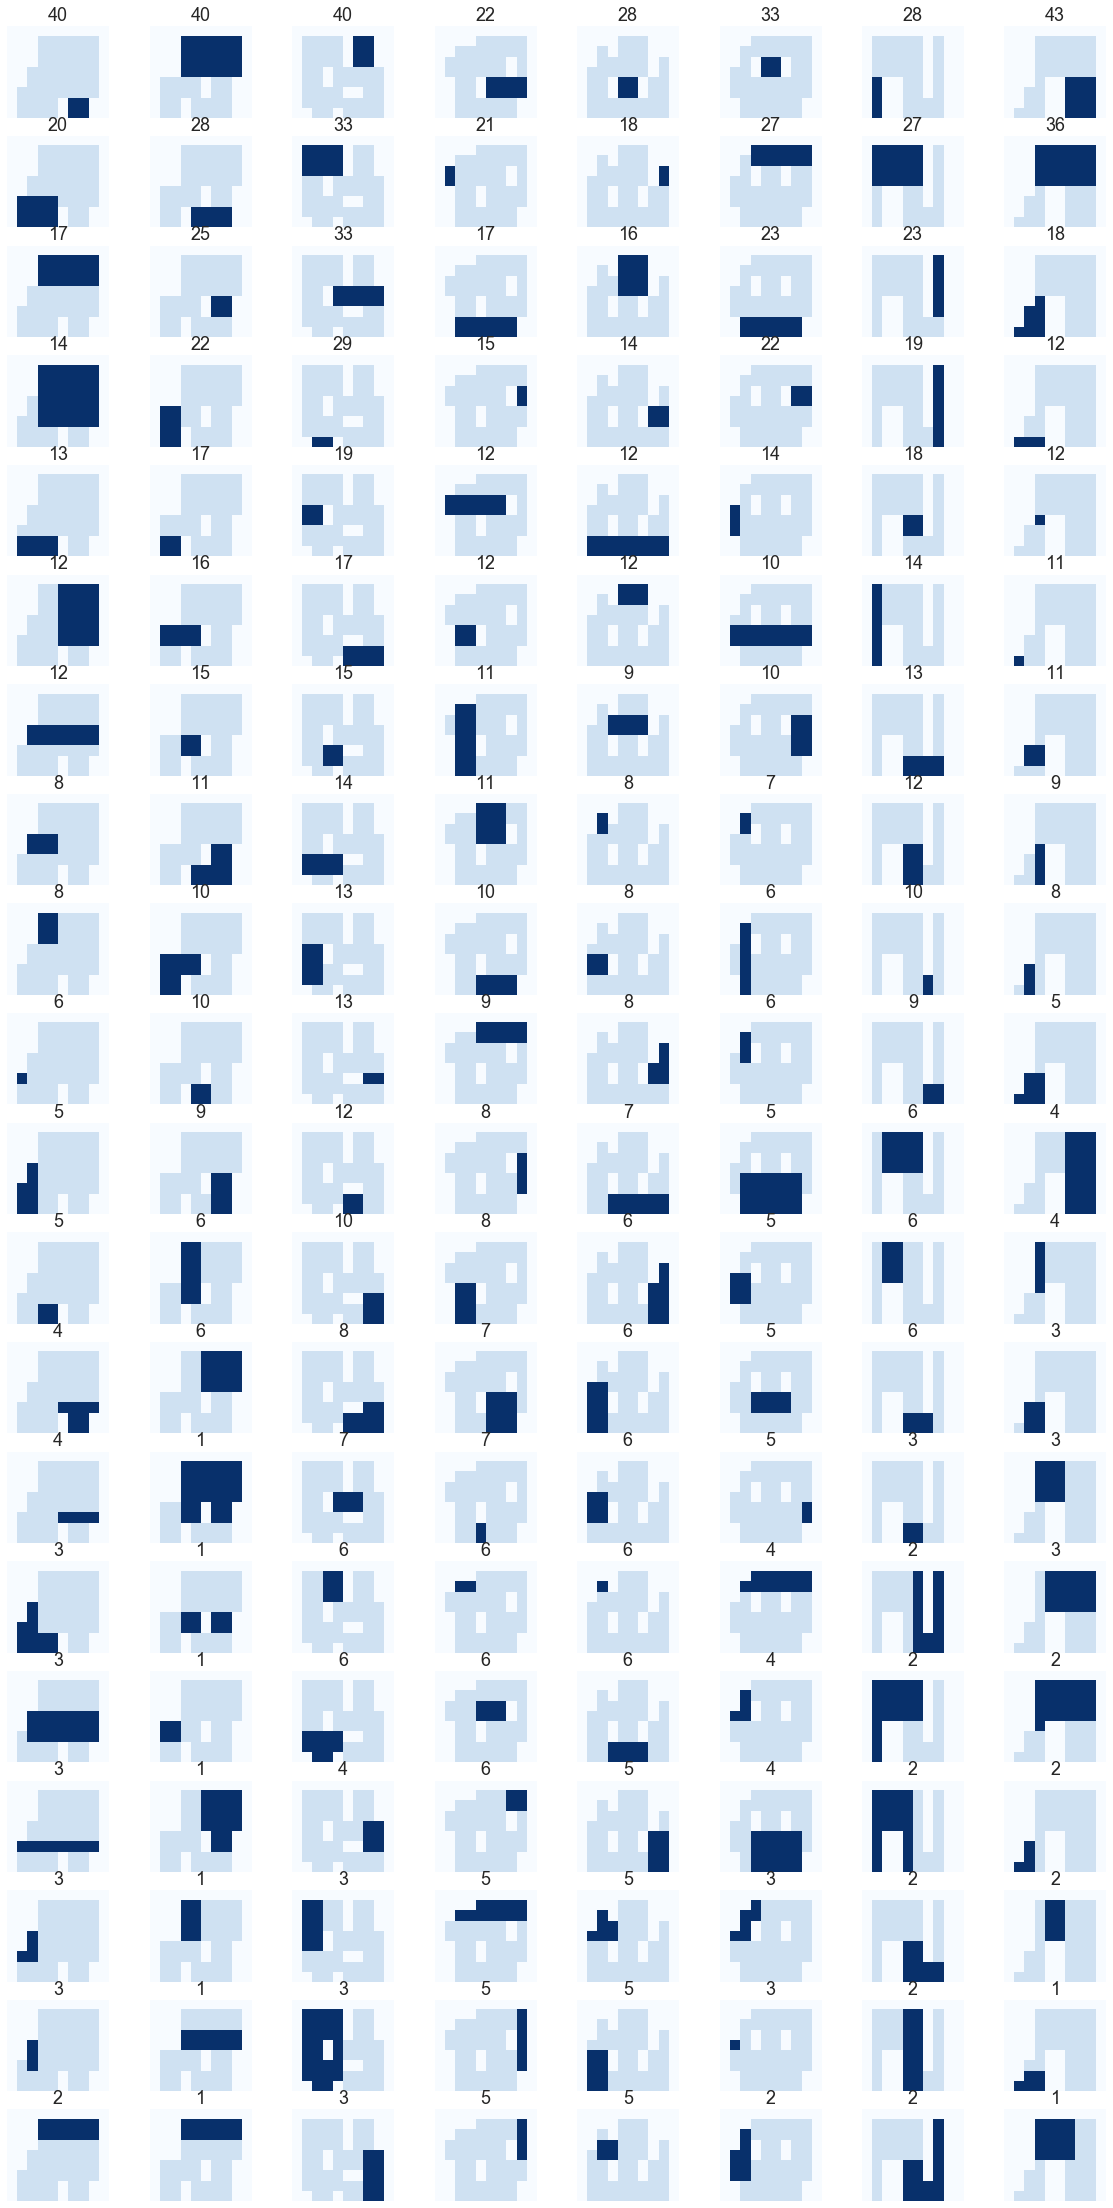

In [282]:
visualize = True

if visualize:

    n_chunks = 20

    fig, axs = plt.subplots(n_chunks, len(targets), figsize=(20,2*n_chunks))

    for i, target in enumerate(targets):
        for j in range(0, n_chunks):
            axs[j,i].axis('off')
            axs[j,i].set_title(str(list(perceptual_chunk_counters[target].values())[j]))
            drawing.show_chunk([list(perceptual_chunk_counters[target].keys())[j]], axs[j,i], target=target, cmap='Blues', cropped=True)
            

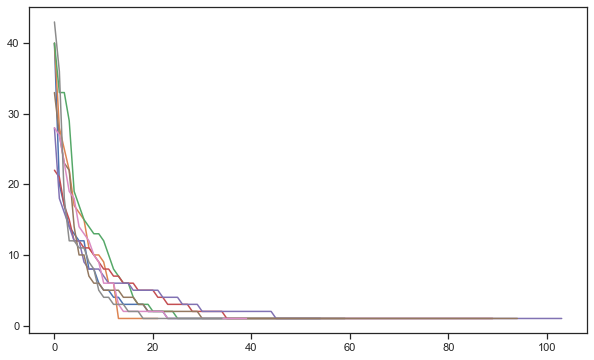

In [283]:
plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
for target in targets:
    plt.plot(list(perceptual_chunk_counters[target].values()))

#### Load in building procedures from block_silhouette, and find all world-deltas for all reconstructions

'world-deltas': change in world state (i.e. squares covered by blocks) between action i and action j, for all i and j.

In [284]:
# load in procedural data from silhouette experiment
silhouette_world_path = os.path.join(silhouette_csv_dir,'procedural_chunks_world_states_{}.p'.format('Exp2Pilot3_all'))
df_proc_world_states = pickle.load(open(silhouette_world_path, "rb" ))


silhouette_trial_path = os.path.join(silhouette_csv_dir,'block_silhouette_{}_good.csv'.format('Exp2Pilot3_all'))
df_proc_trial = pd.read_csv(silhouette_trial_path)

In [285]:
# find world-deltas in procedures
df_proc_chunks = find_world_diffs(df_proc_world_states)

In [286]:
# search for perceptual chunks in world-deltas for each phase
df_occurrences_in_procedures = find_perc_chunks_in_procedures(perceptual_chunk_counters, 
                                                                df_proc_chunks,
                                                                min_count = 0)

In [287]:
min_perceptual_rank = 20
df_top_k = df_occurrences_in_procedures[df_occurrences_in_procedures.perceptual_rank <= min_perceptual_rank]

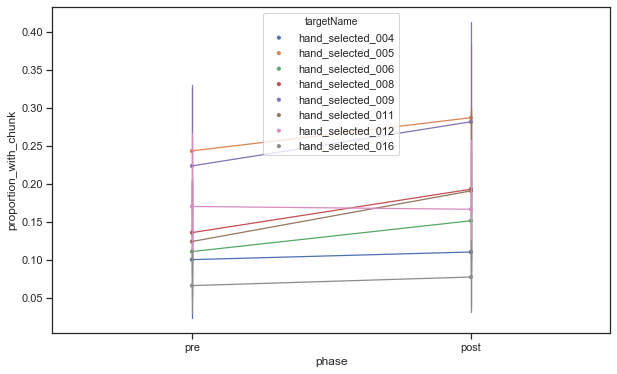

In [288]:
# Were perceptual chunks built more in the first or final repetition? By structure

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
sns.pointplot(data=df_top_k, x='phase', y='proportion_with_chunk', hue='targetName')

<Figure size 1008x720 with 0 Axes>

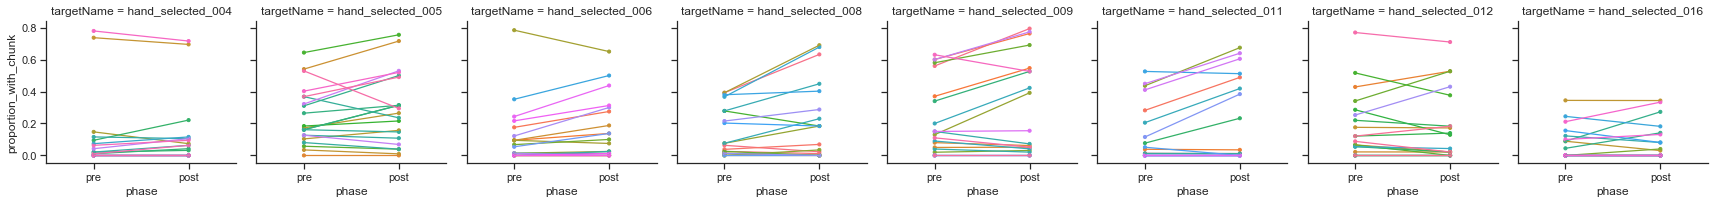

In [289]:
# How many chunks were build more, and how many were built less?

fig = plt.figure(figsize=(14,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(data=df_top_k, col="targetName", hue="chunk_str", col_order=targets)
g.map(sns.pointplot,"phase","proportion_with_chunk", order=['pre','post'])

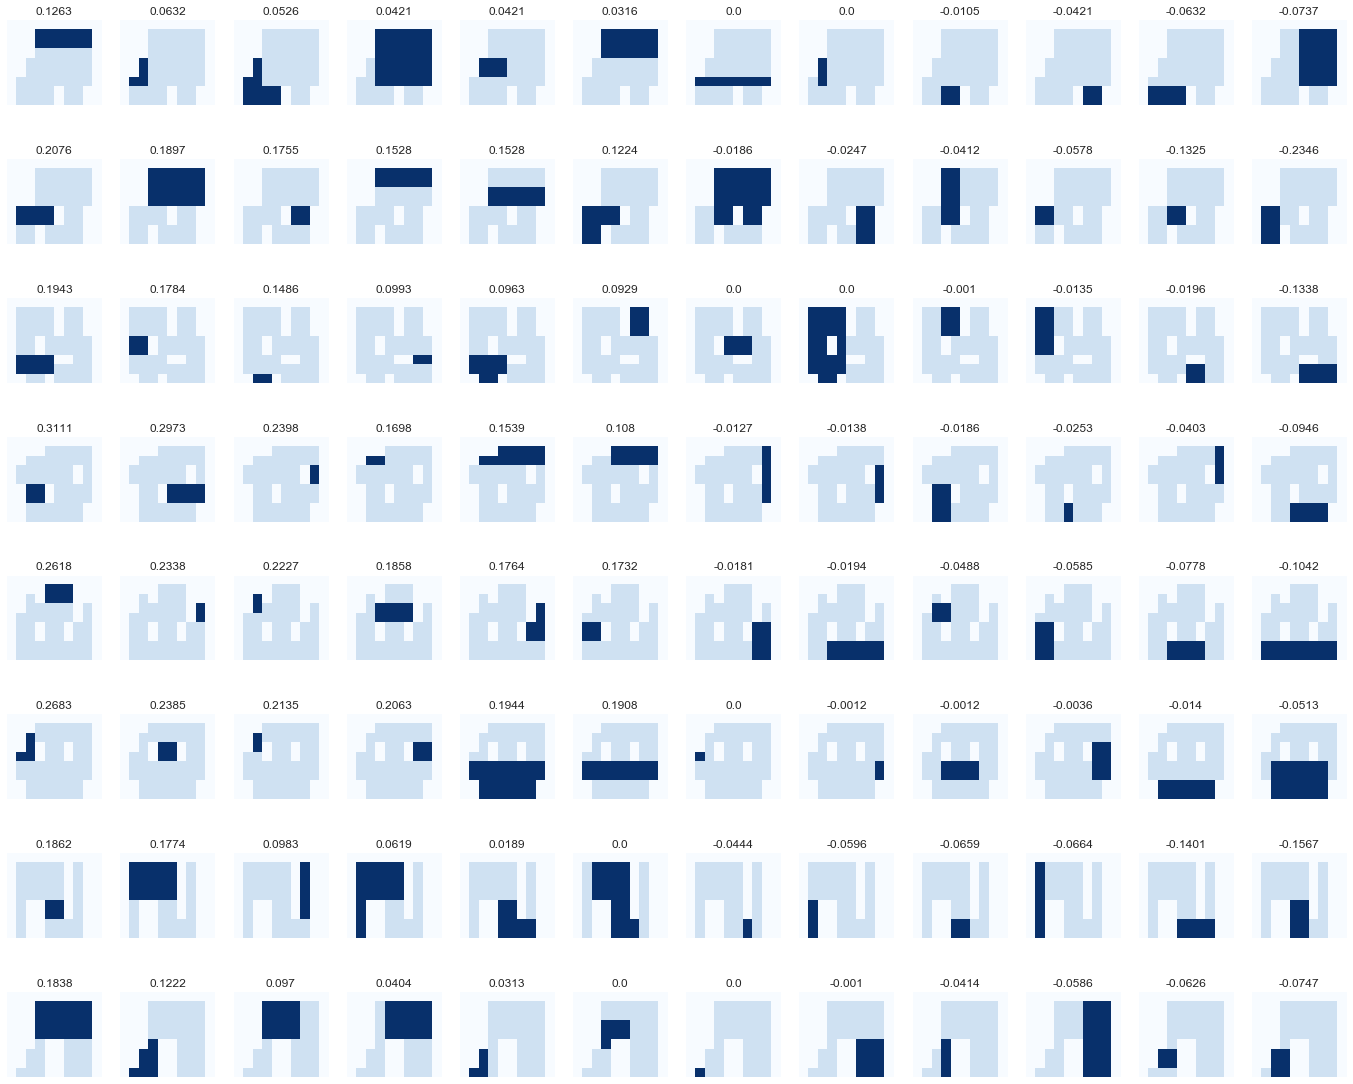

In [290]:
df = df_top_k[df_top_k.phase=='pre']

n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df[df.targetName==target].sort_values('difference', ascending=False).reset_index()
        axs[i,j].axis('off')
        axs[i,j].set_title(str((round(greatest_increase.loc[j,'difference'],4))))
        drawing.show_chunk([greatest_increase.loc[j,'chunk_str']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_decrease = df[df.targetName==target].sort_values('difference', ascending=True).reset_index()
        axs[i,n_chunks*2-1-j].axis('off')
        axs[i,n_chunks*2-1-j].set_title(str((round(greatest_decrease.loc[j,'difference'],4))))
        drawing.show_chunk([greatest_decrease.loc[j,'chunk_str']], axs[i,n_chunks*2-1-j], target=target, cmap='Blues', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

<Figure size 1440x720 with 0 Axes>

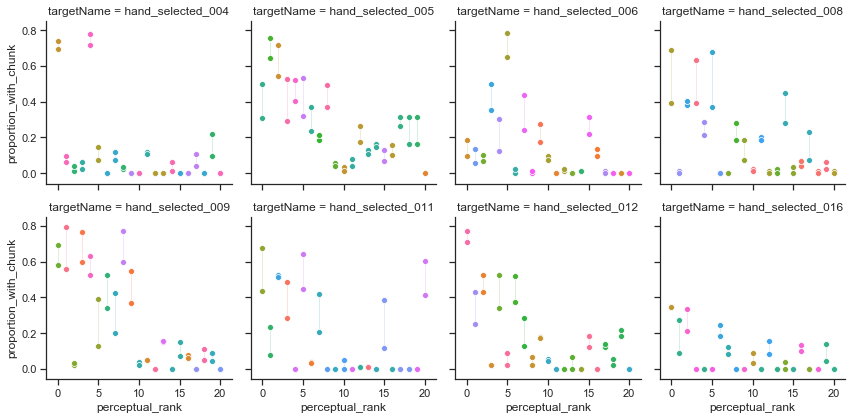

In [259]:
# How many chunks were build more, and how many were built less?

fig = plt.figure(figsize=(20,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 4})
g = sns.FacetGrid(data=df_occurrences_in_procedures[df_occurrences_in_procedures.perceptual_rank <= min_perceptual_rank], col="targetName", col_wrap=4, hue="chunk_str", col_order=targets)
g.map(sns.lineplot, "perceptual_rank", "proportion_with_chunk")
g.map(sns.scatterplot, "perceptual_rank", "proportion_with_chunk")



In [ ]:
# How many chunks were build more, and how many were built less?

df = df_occurrences_in_procedures[(df_occurrences_in_procedures.perceptual_rank <= min_perceptual_rank) &
                                  (df_occurrences_in_procedures.phase <= 'post')]

fig = plt.figure(figsize=(20,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 4})
g = sns.FacetGrid(data=df, col="targetName", col_wrap=4, hue="chunk_str", col_order=targets)
g.map(sns.scatterplot, "perceptual_rank", "proportion_with_chunk")


In [255]:
df_occurrences_in_procedures

,chunk_height,chunk_str,n_with_chunk,perceptual_count,perceptual_rank,phase,proportion_with_chunk,targetName,total_phase_reconstructions,difference,both_zero
0,1.0,0000000000000000000000000000000000000000000000...,70.0,40.0,0.0,pre,0.736842,hand_selected_004,95.0,-0.042105,False
1,1.0,0000000000000000000000000000000000000000000000...,66.0,40.0,0.0,post,0.694737,hand_selected_004,95.0,-0.042105,False
2,1.5,0000000000000000000000000000000000000000000000...,6.0,20.0,1.0,pre,0.063158,hand_selected_004,95.0,0.031579,False
3,1.5,0000000000000000000000000000000000000000000000...,9.0,20.0,1.0,post,0.094737,hand_selected_004,95.0,0.031579,False
4,6.5,0000000000000000000000000000000000000000000000...,1.0,17.0,2.0,pre,0.010526,hand_selected_004,95.0,0.031579,False
...,...,...,...,...,...,...,...,...,...,...,...
997,2.0,0000000000000000000000000000000000000000000000...,41.0,1.0,32.0,post,0.414141,hand_selected_016,99.0,0.103030,False
998,2.5,0000000000000000000000000000000000000000000000...,0.0,1.0,33.0,pre,0.000000,hand_selected_016,90.0,0.000000,True
999,2.5,0000000000000000000000000000000000000000000000...,0.0,1.0,33.0,post,0.000000,hand_selected_016,99.0,0.000000,True
1000,0.5,0000000000000000000000000000000000000000000000...,0.0,1.0,34.0,pre,0.000000,hand_selected_016,90.0,0.000000,True


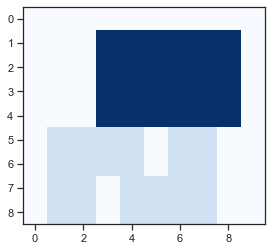

In [153]:
drawing.show_chunk([c], plt, target='hand_selected_005', cmap='Blues', cropped=True)

In [146]:
c = list(perceptual_chunk_counters['hand_selected_005'].keys())[0]